In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# from shap import TreeExplainer, decision_plot
import matplotlib.pyplot as plt
print('Loading...')
df = pd.read_stata('data/ml_data.dta')

Loading...


# Eqn 1 - Linear

In [2]:
# Preprocessing

# No. of women in the household
df['a_women'] = (df['Gender'] == 'Female').astype(int)
women_by_hh = df.groupby('Common_ID')['a_women'].sum()
women_by_hh.name = 't_a_women'
df = df.merge(women_by_hh, left_on='Common_ID', right_index=True)
df['t_add_women'] = df['t_a_women'] - 1
df.rename({
    't_child': 'Total Children in HH',
    't_a_women': 'Total Women in HH',
    't_add_women': 'Total Additional Women in HH'
}, axis=1, inplace=True)

# Encode employment status
def enc_usual_principal_activity(val):
    # 1 "Self-Employed" 2 "Salaried Employee" 3 "Casual Labour" 0 "Not Employed"
    if val < 31:
        return "Self-Employed"
    if val == 31:
        return "Salaried Employee"
    if val in [41, 51]:
        return "Casual Labour"
    if val >= 81:
        return "Not Employed"
    return "EMP NA"
    
df['employment'] = df['usual_principal_activity__status'].map(enc_usual_principal_activity).astype("category")
df['employment'] = df['employment'].cat.reorder_categories(
    ['Not Employed', 'Self-Employed', 'Salaried Employee', 'Casual Labour'], ordered=True
)



X = df[df['Age'] >= 15].copy()
# Discretize Age
X['Age (Young < Old)'] = (X['Age'] > 35).astype(int)

X[['paid_activity_time', 'unpaid_activity_time']] /= 60

# one-hot encode education as int
education_ohe = pd.get_dummies(X.pop('education'), dtype=int, drop_first=True)
X = pd.concat((X, education_ohe), axis=1)

# OHE marital status
# 1 "Never Married" 2 "Currently Married" 3 "Widowed" 4 "Divorced"
marital_status = {1: 'Never Married', 2: 'Currently Married', 3: 'Widowed', 4: 'Divorced'}
X['marital_status'] = X['marital_status'].replace(marital_status).astype('category')
X['marital_status'] = X['marital_status'].cat.reorder_categories(
    ['Never Married', 'Currently Married', 'Widowed', 'Divorced'], ordered=True
)
marital_status_ohe = pd.get_dummies(X.pop('marital_status'), dtype=int, drop_first=True)
X = pd.concat((X, marital_status_ohe), axis=1)

# OHE employment
emp_ohe = pd.get_dummies(X.pop('employment'), dtype=int, drop_first=True)
X = pd.concat((X, emp_ohe), axis=1)

# OHE states
state_ohe = pd.get_dummies(X.pop('state_codes'), dtype=int)
X = pd.concat((X, state_ohe), axis=1)


# (X, y)s of the four regressions

catCols = education_ohe.columns.tolist() + marital_status_ohe.columns.tolist() + emp_ohe.columns.tolist() + state_ohe.columns.tolist()
male_feats = ['Age (Young < Old)', 'Total Children in HH', 'Total Women in HH'] + catCols
female_feats = ['Age (Young < Old)', 'Total Children in HH', 'Total Additional Women in HH'] + catCols

male_X = X[X['Gender'] == 'Male']
female_X = X[X['Gender'] == 'Female']

male_X_paid, male_y_paid = male_X[male_feats], male_X['paid_activity_time']
female_X_paid, female_y_paid = female_X[female_feats], female_X['paid_activity_time']

male_X_unpaid, male_y_unpaid = male_X[male_feats], male_X['unpaid_activity_time']
female_X_unpaid, female_y_unpaid = female_X[female_feats], female_X['unpaid_activity_time']

print(male_X_paid.shape)
print(male_X_unpaid.shape)
print(female_X_paid.shape)
print(female_X_unpaid.shape)

/tmp/ipykernel_89677/653545262.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['a_women'] = (df['Gender'] == 'Female').astype(int)
/tmp/ipykernel_89677/653545262.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['t_add_women'] = df['t_a_women'] - 1
/tmp/ipykernel_89677/653545262.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragme

(192265, 49)
(192265, 49)
(189851, 49)
(189851, 49)


In [3]:
male_X.shape

(192265, 197)

In [4]:
female_X.shape

(189851, 197)

In [5]:
mx = male_X[male_feats + ['paid_activity_time', 'unpaid_activity_time' ]]
fx = female_X[female_feats + ['paid_activity_time', 'unpaid_activity_time' ]]
mx.head()

,Age (Young < Old),Total Children in HH,Total Women in HH,Upto Middle School,Secondary,Higher Secondary,Graduate and above,Currently Married,Widowed,Divorced,...,KAR,GOA,LD,KER,TN,PU,A&N,TEL,paid_activity_time,unpaid_activity_time
0,1,1.0,2,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,8.0,0.75
2,0,1.0,2,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,6.0,0.25
5,1,0.0,2,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,7.0,0.00
7,0,0.0,2,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.0,4.25
13,0,0.0,2,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0.0,0.00


In [6]:
fx.head()

,Age (Young < Old),Total Children in HH,Total Additional Women in HH,Upto Middle School,Secondary,Higher Secondary,Graduate and above,Currently Married,Widowed,Divorced,...,KAR,GOA,LD,KER,TN,PU,A&N,TEL,paid_activity_time,unpaid_activity_time
1,1,1.0,1,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,5.0,3.75
3,0,1.0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0.0,10.75
4,1,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0.0,1.75
6,1,0.0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0.0,3.75
8,0,0.0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0.0,2.75


In [9]:
189851+192265

382116

In [8]:
mx['Gender'] = 'Male'
fx['Gender'] = 'Female'
xout = pd.concat((mx, fx), axis=0, ignore_index=True)
xout.shape

/tmp/ipykernel_89677/3552200601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mx['Gender'] = 'Male'
/tmp/ipykernel_89677/3552200601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fx['Gender'] = 'Female'


(382116, 53)

In [10]:
xout.to_csv('data/eqn1_male_female_paid_unpaid.csv', index=False)

(192265, 49)
0.44369142202976686


<Axes: >

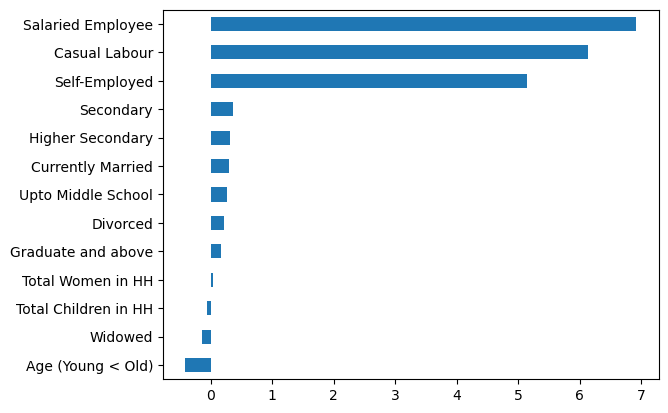

In [3]:
# Linear Regressions
# 1. Male, paid
print(male_X_paid.shape)


male_paid_lr = LinearRegression().fit(male_X_paid, male_y_paid)
print(male_paid_lr.score(male_X_paid, male_y_paid))



pd.Series(male_paid_lr.coef_[nonStateIx], index=male_paid_lr.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

(192265, 50)
0.12375109212443136


<Axes: >

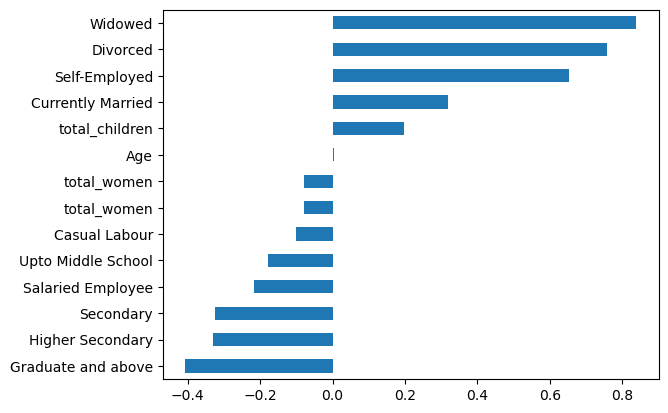

In [5]:
# Regressions
# 1. Male, unpaid
print(male_X_unpaid.shape)
male_unpaid_lr = LinearRegression().fit(male_X_unpaid, male_y_unpaid)
print(male_unpaid_lr.score(male_X_unpaid, male_y_unpaid))
pd.Series(male_unpaid_lr.coef_[nonStateIx], index=male_unpaid_lr.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

(189851, 50)
0.5279792307718574


<Axes: >

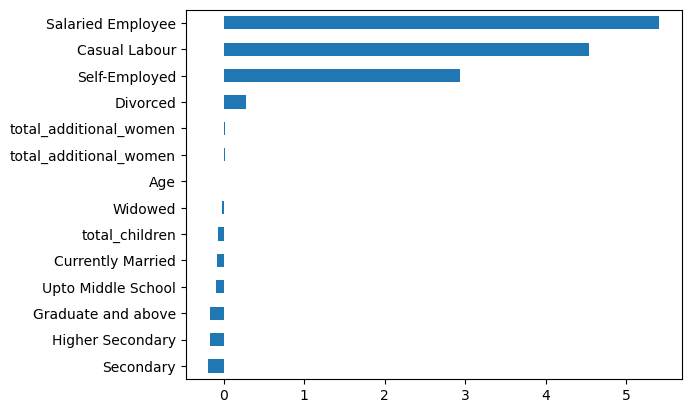

In [6]:
# Regressions
# 1. Female, paid
print(female_X_paid.shape)
female_paid_lr = LinearRegression().fit(female_X_paid, female_y_paid)
print(female_paid_lr.score(female_X_paid, female_y_paid))
pd.Series(female_paid_lr.coef_[nonStateIx], index=female_paid_lr.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

(189851, 50)
0.43100128429001305


<Axes: >

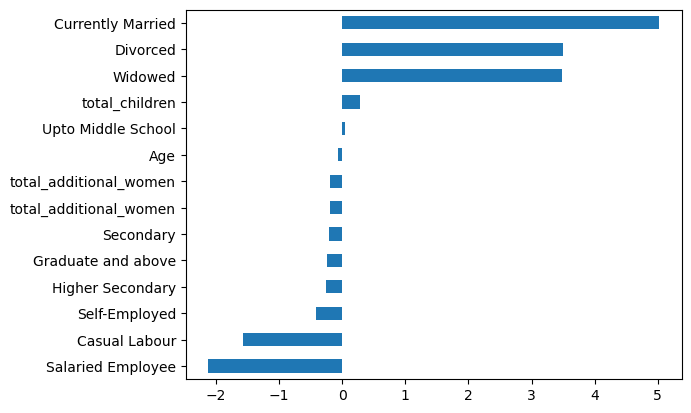

In [7]:
# Regressions
# 1. Female, unpaid
print(female_X_unpaid.shape)
female_unpaid_lr = LinearRegression().fit(female_X_unpaid, female_y_unpaid)
print(female_unpaid_lr.score(female_X_unpaid, female_y_unpaid))
pd.Series(female_unpaid_lr.coef_[nonStateIx], index=female_unpaid_lr.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

---

# Decision Trees - Eqn 1

(192265, 49)
0.53690815603104


<Axes: >

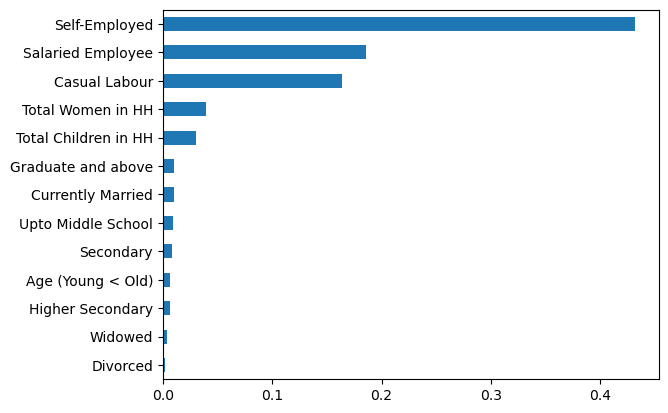

In [3]:
nonStateIx = ~male_X_paid.columns.isin(state_ohe.columns)

print(male_X_paid.shape)
male_paid_tree = DecisionTreeRegressor().fit(male_X_paid, male_y_paid)
print(male_paid_tree.score(male_X_paid, male_y_paid))
pd.Series(male_paid_tree.feature_importances_[nonStateIx], index=male_paid_tree.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

(192265, 49)
0.2910962979385082


<Axes: >

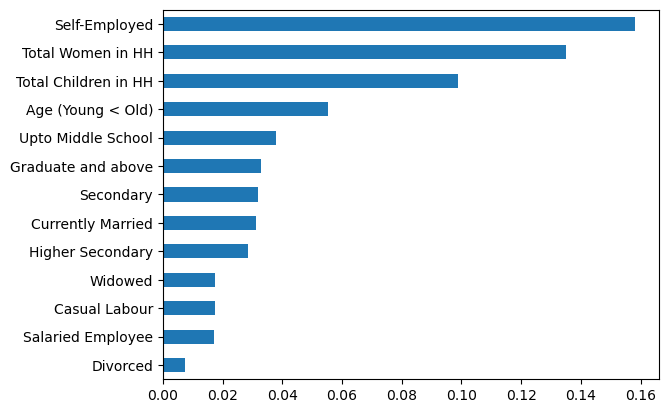

In [4]:
print(male_X_unpaid.shape)
male_unpaid_tree = DecisionTreeRegressor().fit(male_X_unpaid, male_y_unpaid)
print(male_unpaid_tree.score(male_X_unpaid, male_y_unpaid))
pd.Series(male_unpaid_tree.feature_importances_[nonStateIx], index=male_unpaid_tree.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

(189851, 49)
0.6485548159088178


<Axes: >

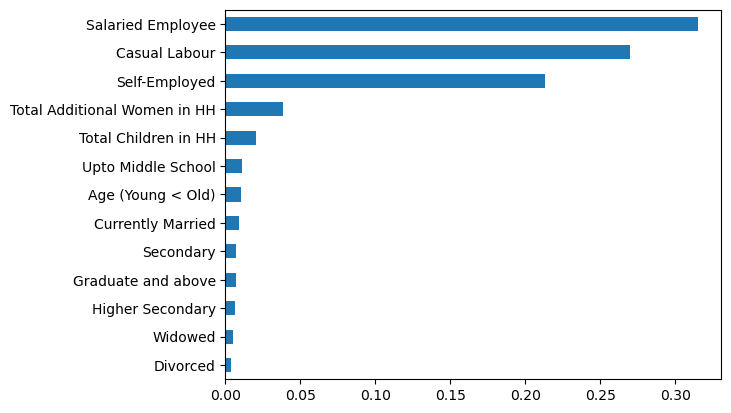

In [5]:
print(female_X_paid.shape)
female_paid_tree = DecisionTreeRegressor().fit(female_X_paid, female_y_paid)
print(female_paid_tree.score(female_X_paid, female_y_paid))
pd.Series(female_paid_tree.feature_importances_[nonStateIx], index=female_paid_tree.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

(189851, 49)
0.5276569392593315


<Axes: >

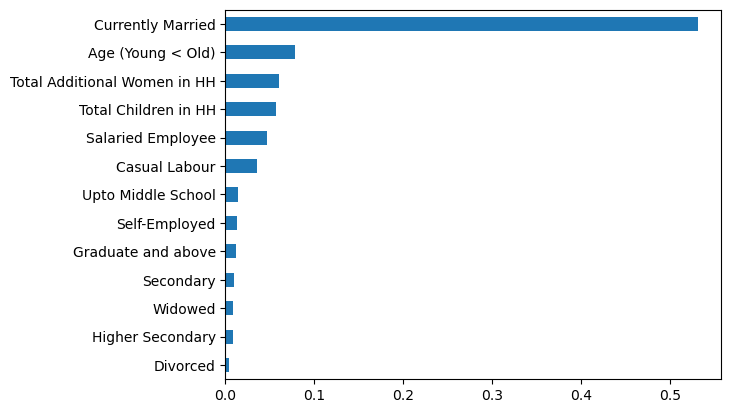

In [6]:
print(female_X_unpaid.shape)
female_unpaid_tree = DecisionTreeRegressor().fit(female_X_unpaid, female_y_unpaid)
print(female_unpaid_tree.score(female_X_unpaid, female_y_unpaid))
pd.Series(female_unpaid_tree.feature_importances_[nonStateIx], index=female_unpaid_tree.feature_names_in_[nonStateIx]).sort_values().plot(kind='barh')

---

# Eqn 3:

In [11]:
# Outputs: paid time, unpaid time, leisure, cooking, cleaning, collecting firewood, washing clothes, domestic chores, care work
# Features: social group, religion, sector, MPCE qrt, age, education, marital status, employment
# HH Features: piped gas, electricity, washing type, sweeping type, children (below and above 6 years), adult pwd, unemployed working age men

In [12]:
fX = df[df['Age'] >= 15].copy()
fX = fX[fX['Gender'] == 'Female']
fX['Age (Young < Old)'] = (fX['Age'] > 35).astype(int)

# features
social_ohe = pd.get_dummies(fX.pop('Social_group_'), dtype=int, drop_first=True)
religion_ohe = pd.get_dummies(fX.pop('religion'), dtype=int, drop_first=True)

fX['sector'].replace({1.0: 'Rural', 2.0: 'Urban'}, inplace=True)
fX['sector'] = fX['sector'].astype('category').cat.reorder_categories(['Rural', 'Urban'], ordered=True)
sector_ohe = pd.get_dummies(fX.pop('sector'), dtype=int, drop_first=True)

mpce_ohe = pd.get_dummies(fX.pop('MPCE_qrt'), dtype=int, drop_first=True)
education_ohe = pd.get_dummies(fX.pop('education'), dtype=int, drop_first=True)

ms_enc = {1: 'Never Married', 2: 'Currently Married', 3: 'Widowed', 4: 'Divorced'}
fX['marital_status'] = fX['marital_status'].replace(ms_enc).astype('category')
fX['marital_status'] = fX['marital_status'].cat.reorder_categories(
    ['Never Married', 'Currently Married', 'Widowed', 'Divorced'], ordered=True
)
marital_status_ohe = pd.get_dummies(fX.pop('marital_status'), dtype=int, drop_first=True)
emp_ohe = pd.get_dummies(fX.pop('employment'), dtype=int, drop_first=True)
state_ohe = pd.get_dummies(fX.pop('state_codes'), dtype=int)

# Household composition
piped_gas = pd.get_dummies(fX.pop('piped_gas'), dtype=int, drop_first=True)
wired_source = pd.get_dummies(fX.pop('wired_source'), dtype=int, drop_first=True)
washing_type = pd.get_dummies(fX.pop('washing_type'), dtype=int, prefix='washing')
sweeping_type = pd.get_dummies(fX.pop('sweeeping_type'), dtype=int, prefix='sweeping')
child = pd.get_dummies(fX.pop('child'), dtype=int, drop_first=True)
adult_pwd = pd.get_dummies(fX.pop('old'), dtype=int, drop_first=True)
unemp_men = fX.pop('n_unemp_men')


target_cols = ['paid_activity_time', 'unpaid_activity_time', 'leisure_time', 'cooking_time', 'cleaning_time', 'firewood_time', 'washing_time', 'hh_time', 'care_time']
target_names = ['Time Spent on Paid Work',
                'Time Spent on Unpaid Work',
                'Time Spent on Leisure',
                'Time Spent Cooking',
                'Time Spent Cleaning',
                'Time Spent Collecting Firewood',
                'Time Spent Washing',
                'Time Spent on Domestic Chores',
                'Time Spent on Care Work'
               ]
featX = pd.concat([
    social_ohe,
    religion_ohe,
    sector_ohe,
    mpce_ohe,
    fX[['Age (Young < Old)']],
    education_ohe,
    marital_status_ohe,
    emp_ohe,
    piped_gas,
    wired_source,
    washing_type,
    sweeping_type,
    child,
    adult_pwd,
    unemp_men,
    state_ohe], axis=1)
# Typos:
typos = {
    'HH with children beloww age 6 ': 'Child',
    'HH with elderly person or PWD': 'Dependent Adult',
    'n_unemp_men': 'Unemployed Working-age Men'
}
featX.rename(typos, axis=1, inplace=True)

In [13]:
target_renamed = {c: f'target_{c}' for c in target_cols}
fX.rename(target_renamed, axis=1, inplace=True)

In [16]:
xout = pd.concat((featX, fX[target_renamed.values()]), axis=1)

In [19]:
xout.to_csv('data/eqn3_female_activity.csv', index=False)

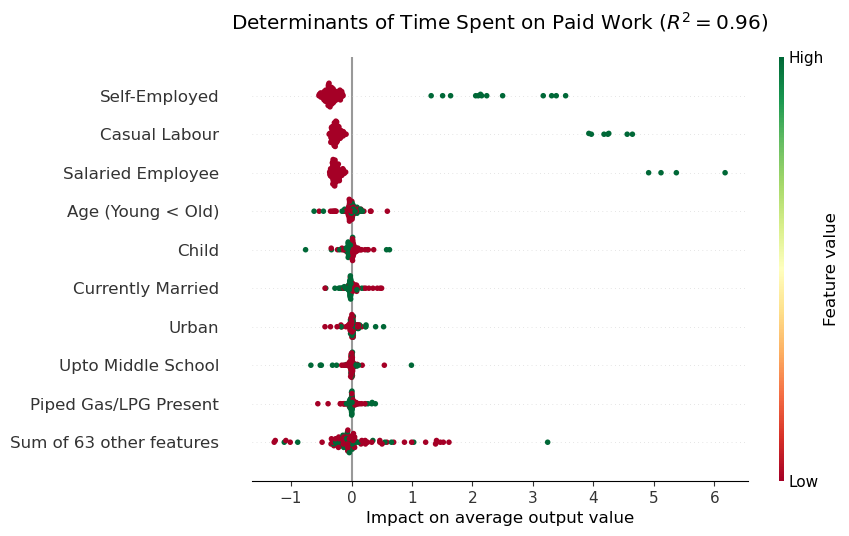

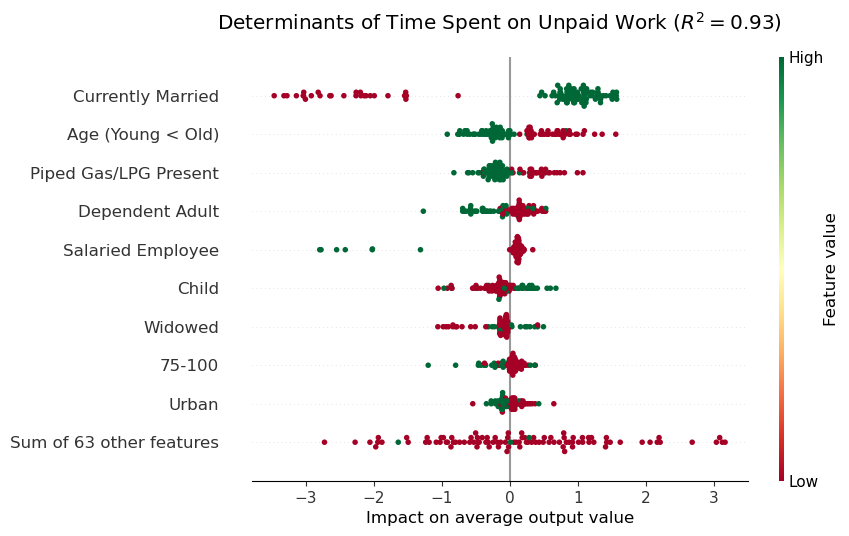

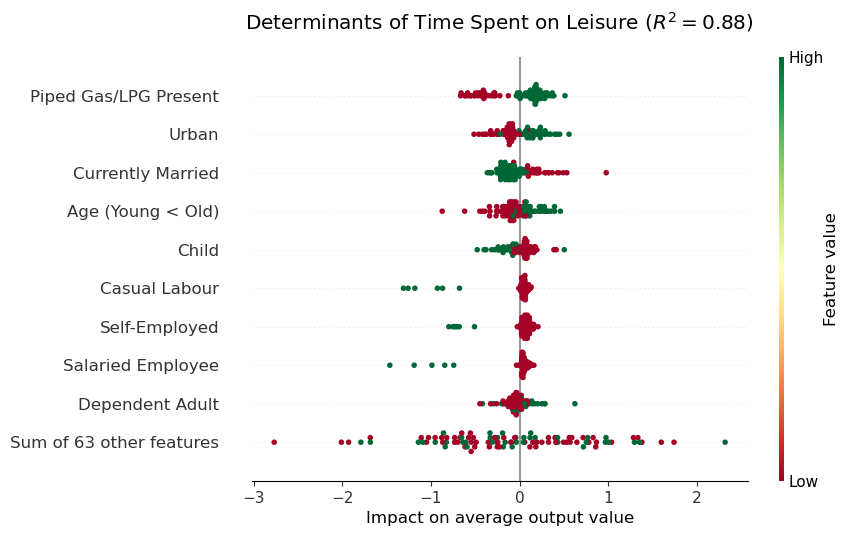

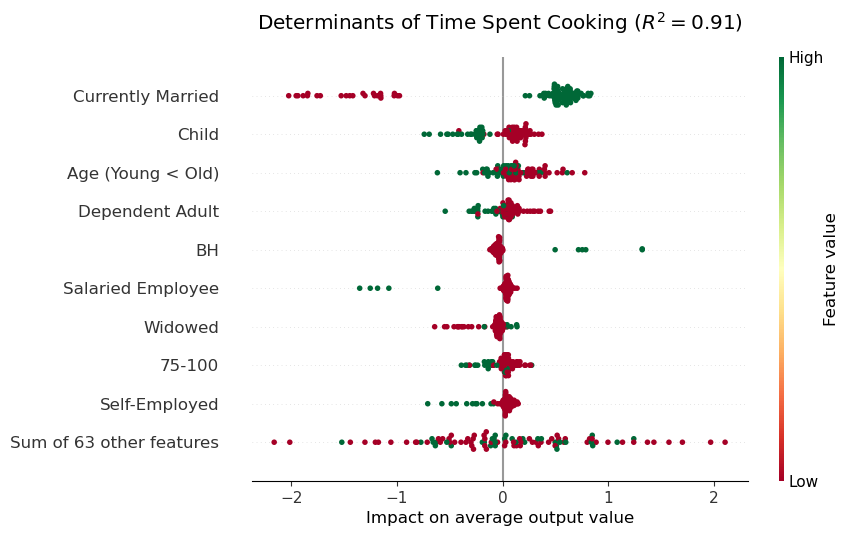

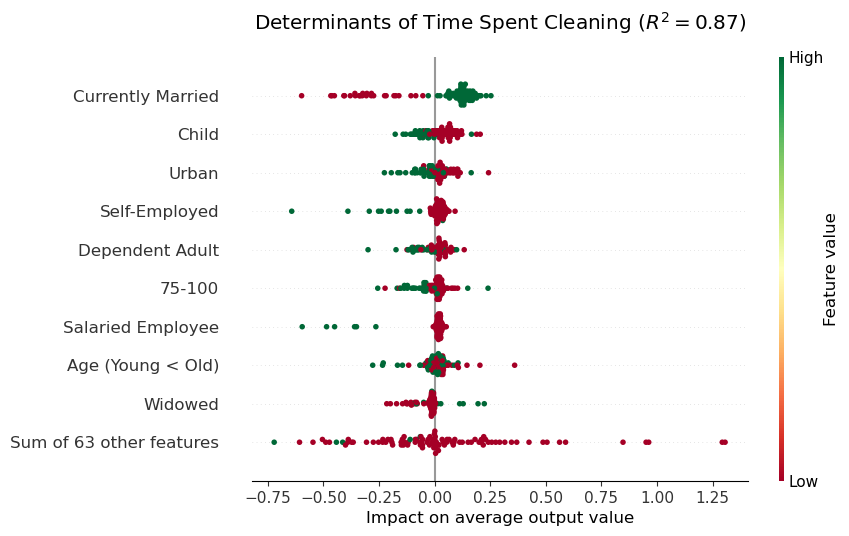

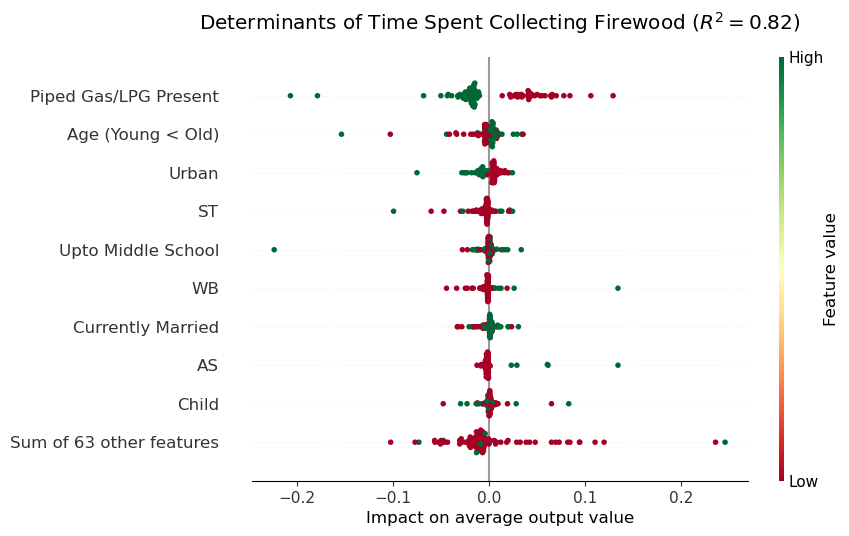

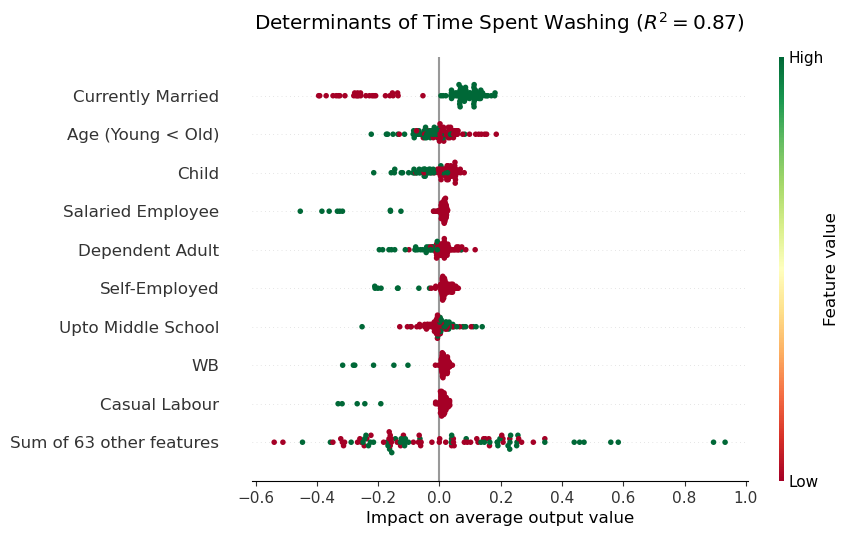

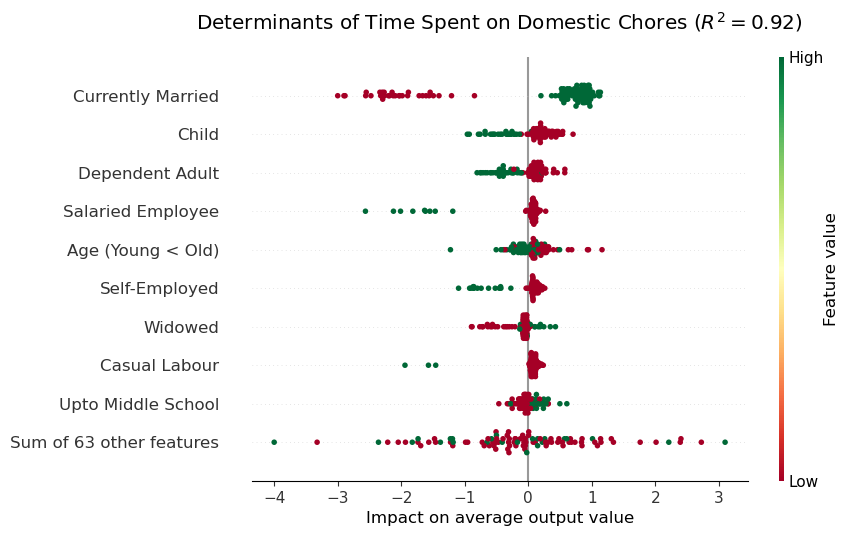

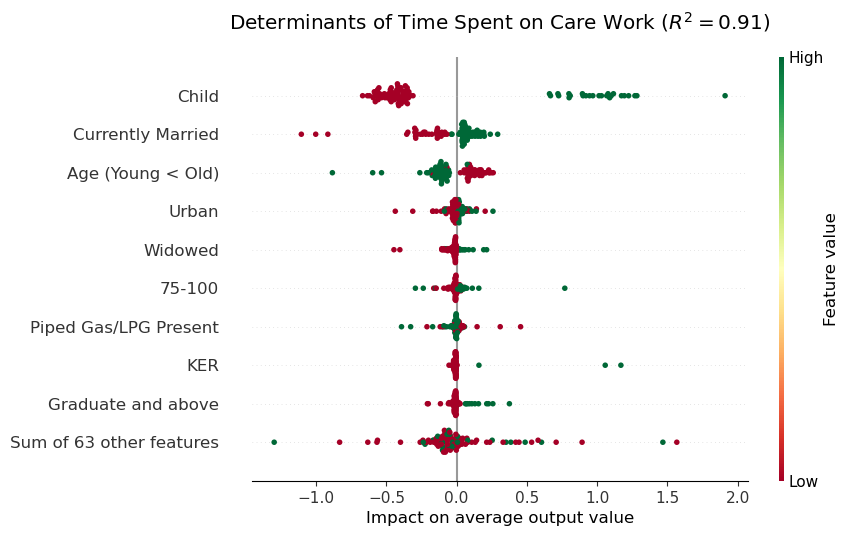

In [28]:
trees = {}
scores = [0.96, 0.93, 0.88, 0.91, 0.87, 0.82, 0.87, 0.92, 0.91]
for col, name, score in zip(target_cols, target_names, scores):
    tree = DecisionTreeRegressor().fit(featX, fX[col] / 60)
    samples = featX.sample(100)
    exp = TreeExplainer(tree)
    vals = exp(samples, check_additivity=False)
    plt.figure()
    beeswarm(vals, color='RdYlGn', show=False)
    modify_ax(plt.gca(), "Determinants of " + name + f" ($R^{2} = {score}$)")

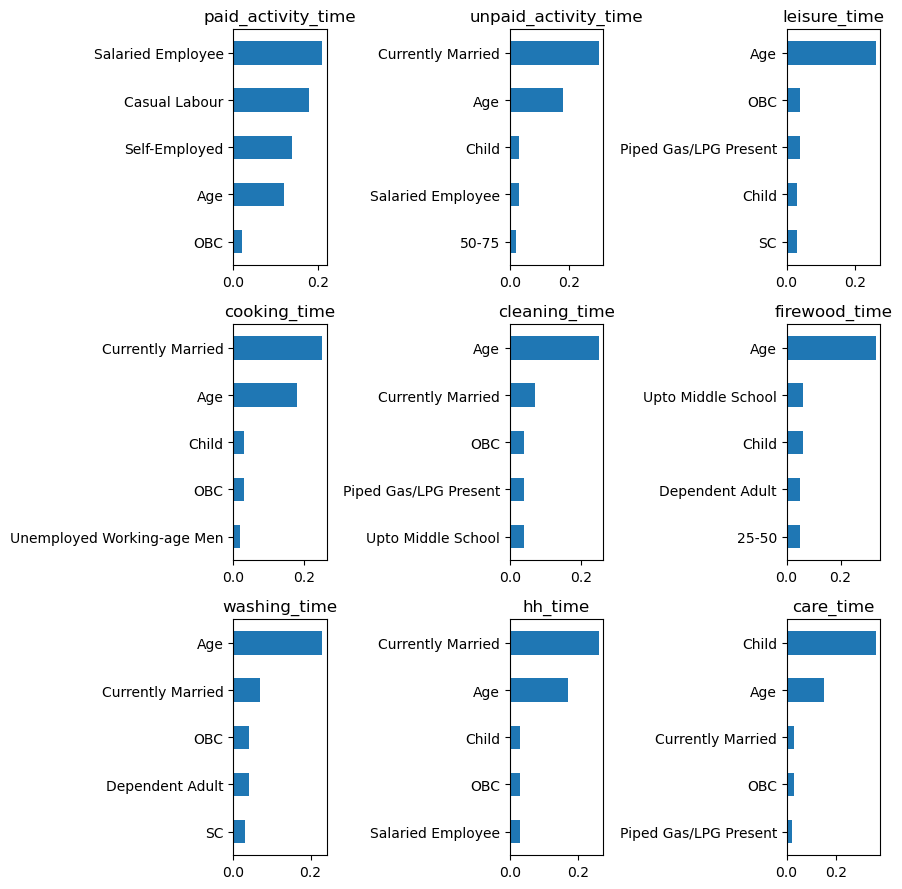

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
ax = ax.ravel()
for i, col in enumerate(target_cols):
    tree = trees[col]
    nonStateIx = ~featX.columns.isin(state_ohe.columns)
    pd.Series(tree.feature_importances_[nonStateIx], index=tree.feature_names_in_[nonStateIx]).round(2).sort_values().tail(5).plot(kind='barh', ax=ax[i])
    ax[i].set_title(col)
plt.tight_layout()

---

## Explanations

In [9]:
from shap import TreeExplainer, summary_plot
from shap.plots import beeswarm

In [10]:
def modify_ax(ax, title):
    # ax.set_title('Determinants of Time Spent by Men on Paid Work ($R^{2}$ = 0.73)', fontsize='x-large', pad=20)
    ax.set_title(title, fontsize='x-large', pad=20)
    ax.tick_params(axis='y', labelsize='large')
    ax.set_xlabel('Impact on average output value', fontsize='large')

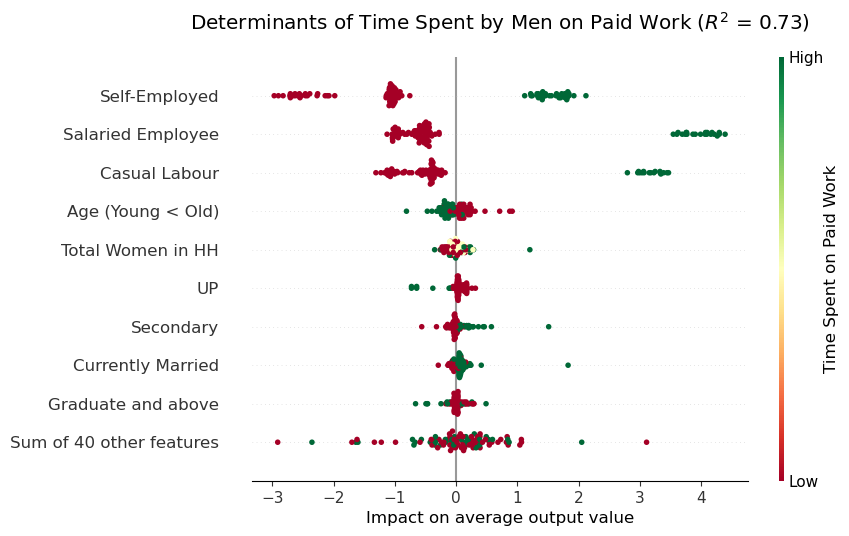

In [11]:
exp = TreeExplainer(male_paid_tree)
samples = male_X_paid.sample(100)
vals = exp(samples)
beeswarm(vals, color='RdYlGn', show=False, color_bar_label='Time Spent on Paid Work')
modify_ax(plt.gca(), 'Determinants of Time Spent by Men on Paid Work ($R^{2}$ = 0.73)')

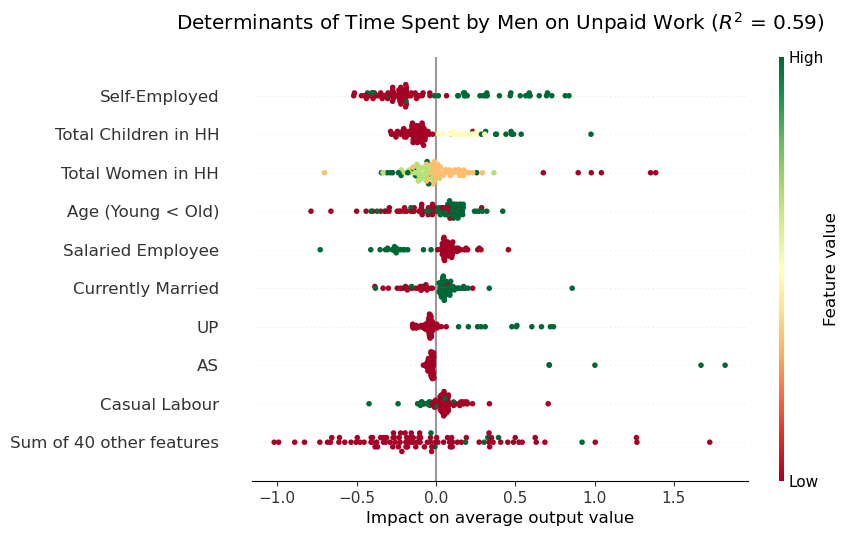

In [12]:
exp = TreeExplainer(male_unpaid_tree)
samples = male_X_unpaid.sample(100)
vals = exp(samples)
beeswarm(vals, color='RdYlGn', show=False)
modify_ax(plt.gca(), 'Determinants of Time Spent by Men on Unpaid Work ($R^{2}$ = 0.59)')

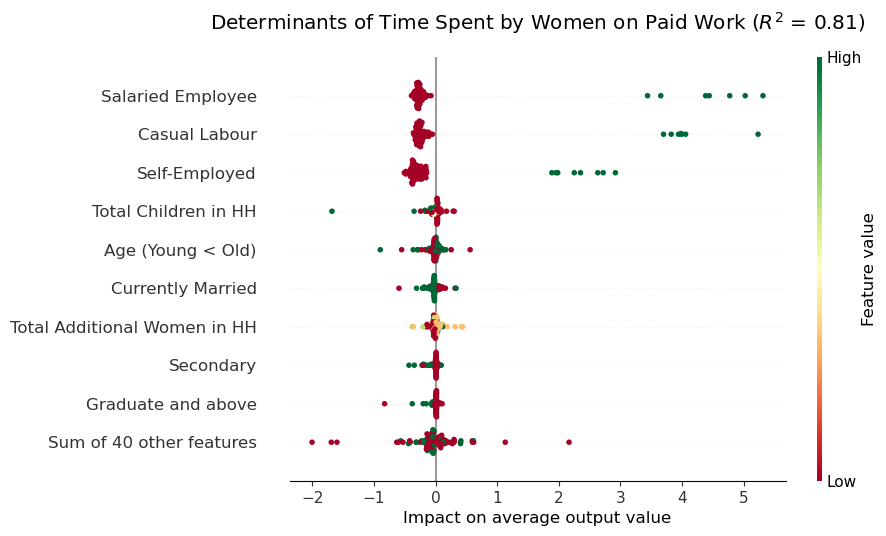

In [13]:
exp = TreeExplainer(female_paid_tree)
samples = female_X_paid.sample(100)
vals = exp(samples)
beeswarm(vals, color='RdYlGn', show=False)
modify_ax(plt.gca(), "Determinants of Time Spent by Women on Paid Work ($R^{2}$ = 0.81)")

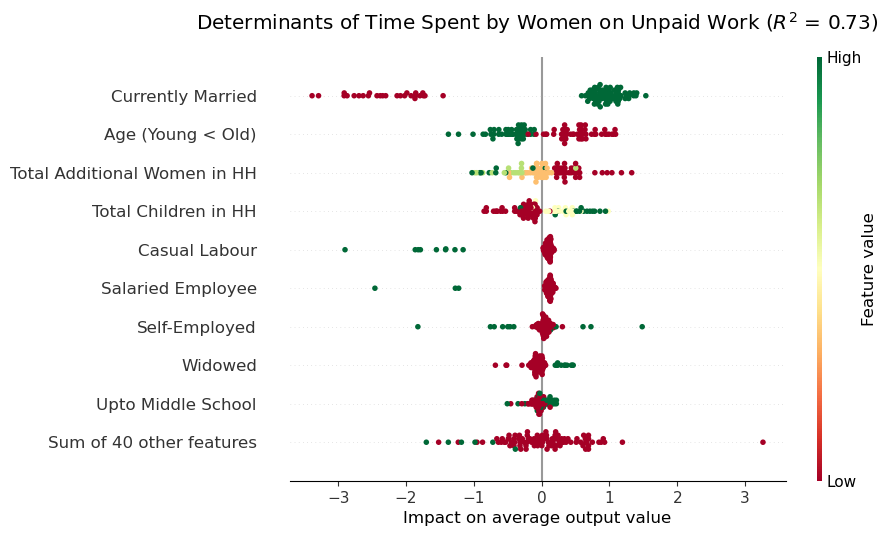

In [15]:
exp = TreeExplainer(female_unpaid_tree)
samples = female_X_unpaid.sample(100)
vals = exp(samples)
beeswarm(vals, color='RdYlGn', show=False)
modify_ax(plt.gca(), "Determinants of Time Spent by Women on Unpaid Work ($R^{2}$ = 0.73)")

In [20]:
# Beeswams of eqn3

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was 5.292696, while the model output was 5.291667. If this difference is acceptable you can set check_additivity=False to disable this check.

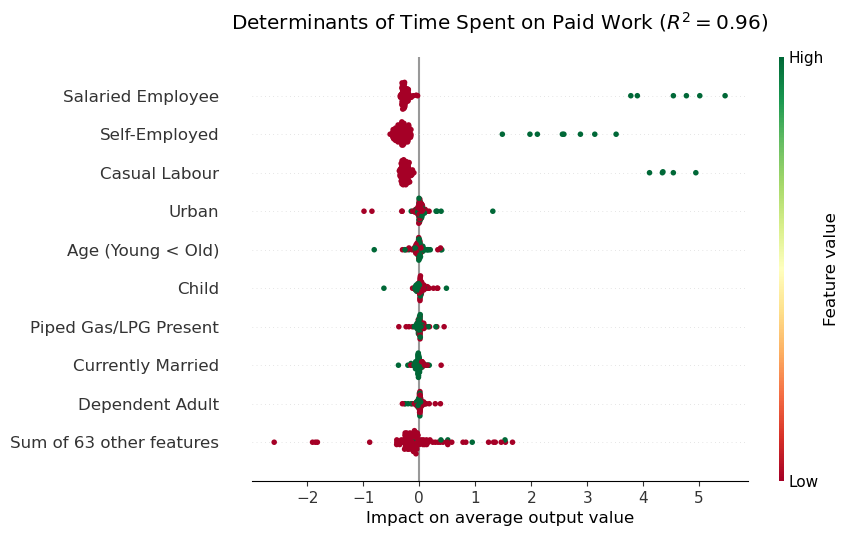

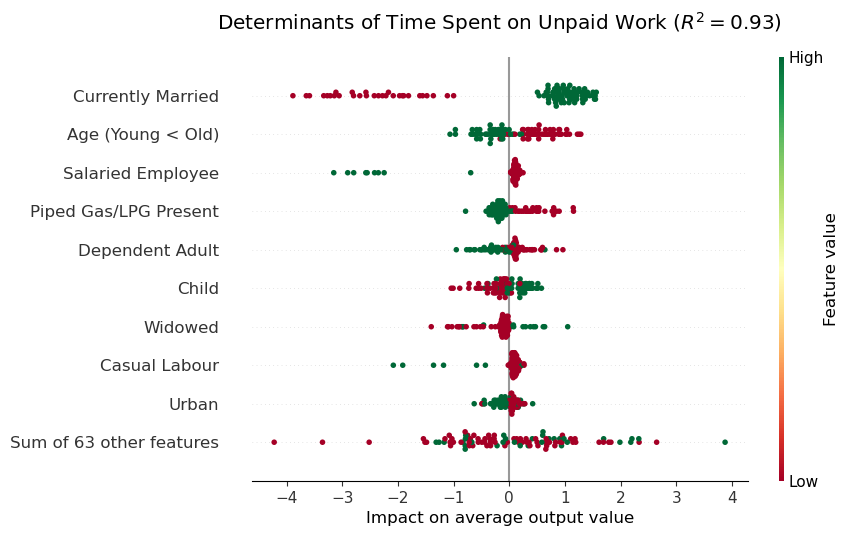

In [16]:

for col, name, score in zip(target_cols, target_names, scores):
    tree = trees[col]
    exp = TreeExplainer(tree)
    samples = featX.sample(100)
    vals = exp(samples)
    plt.figure()
    beeswarm(vals, color='RdYlGn', show=False)
    modify_ax(plt.gca(), "Determinants of " + name + f" ($R^{2} = {score}$)")

In [17]:
samples.shape

(100, 72)

In [18]:
tree.n_features_in_

72